In [ ]:
import os
from dotenv import load_dotenv

import pandas as pd
import numpy as np
import seaborn as sns

import mlflow

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils import resample

In [ ]:
year = 2021
month = 1
color = "yellow"

In [ ]:
### Read the 01-2021 data from the website
# Download the data
if not os.path.exists(f"./data/{color}_tripdata_{year}-{month:02d}.parquet"):
    os.system(f"wget -P ./data https://d37ci6vzurychx.cloudfront.net/trip-data/{color}_tripdata_{year}-{month:02d}.parque")
# https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2021-01.parquet    

In [ ]:
# Load the data
df = pd.read_parquet(f"./data/{color}_tripdata_{year}-{month:02d}.parquet")

In [ ]:
load_dotenv()
MLFLOW_TRACKING_URI=os.getenv("MLFLOW_TRACKING_URI")
MLFLOW_TRACKING_URI

In [ ]:
# Set up the connection to MLflow
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)

# Setup the MLflow experiment 
mlflow.set_experiment("yellow-taxi-trip-duration-rf")

In [ ]:
df.head()
df.info()

In [ ]:
# Look for missing values
df.isnull().sum()

In [ ]:
features = ["PULocationID", "DOLocationID", "trip_distance", "passenger_count", "tpep_pickup_datetime"]
target = 'duration'

In [ ]:
# calculate the trip duration in minutes and drop trips that are less than 1 minute and more than 2 hours
def calculate_trip_duration_in_minutes(df):
    df["trip_duration_minutes"] = (df["tpep_dropoff_datetime"] - df["tpep_pickup_datetime"]).dt.total_seconds() / 60
    df = df[(df["trip_duration_minutes"] >= 1) & (df["trip_duration_minutes"] <= 60)]
    return df

In [ ]:
# Time of the day in minutes as feature
def get_days_minutes(date_time):
    return date_time.hour * 60 + date_time.minute

In [ ]:
### Preprocessing as a function. Must be applied before pipeline, because the X/Y split is based upon
### the creation of df.trip_duration_minutes
def preprocess(df):
    df = df.copy()
    df = calculate_trip_duration_in_minutes(df)
    df["pickup_time_minutes"] = df["tpep_pickup_datetime"].apply(lambda x: get_days_minutes(x))
    categorical_features = ["PULocationID", "DOLocationID"]
    df[categorical_features] = df[categorical_features].astype(str)
    df['trip_route'] = df["PULocationID"] + "_" + df["DOLocationID"]
    df = df[['trip_route', 'trip_distance', 'pickup_time_minutes', 'passenger_count', 'trip_duration_minutes']]
    return df


In [ ]:
df_preprocessed = preprocess(df)
### Resample Data for faster computation



In [ ]:
n_sample = len(df_preprocessed) // 3
df_pre_resampled = resample(df_preprocessed, n_samples=n_sample, replace=False, random_state=42)

In [ ]:
y=df_pre_resampled["trip_duration_minutes"]
X=df_pre_resampled.drop(columns=["trip_duration_minutes"])
#x_columns = X.columns

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)


In [ ]:
impute_columns = ["passenger_count"]
encode_columns = ["trip_route"]

In [17]:
# Define Parameter-Grid
param_grid = {"RF__n_estimators": [10, 50, 100, 200],
              "RF__max_depth": [5, 9, 13, 17],
              "RF__min_samples_leaf": [50, 100, 200, 500],
              "RF__max_features":["sqrt"]}

transformer = ColumnTransformer(
    [("imputer", SimpleImputer(strategy="most_frequent"), impute_columns),
    ("encoder", OneHotEncoder(drop=None,handle_unknown="ignore"), encode_columns)],
    remainder="passthrough"
)

pipeline = Pipeline([("transformer", transformer),
                     ("RF", RandomForestRegressor())],
                    )

model = RandomizedSearchCV(pipeline, param_grid, n_iter = 20, scoring="neg_root_mean_squared_error")
model.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('transformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('imputer',
                                                                               SimpleImputer(strategy='most_frequent'),
                                                                               ['passenger_count']),
                                                                              ('encoder',
                                                                               OneHotEncoder(handle_unknown='ignore'),
                                                                               ['trip_route'])])),
                                             ('RF', RandomForestRegressor())]),
                   n_iter=20,
                   param_distributions={'RF__max_depth': [5, 9, 13, 17],
                                        'RF__max_features': ['sqrt'],
                                        'RF__min_samples_leaf': [50, 100, 200,
                                                                 500],
                                        'RF__n_estimators': [10, 50, 100, 200]},
                   scoring='neg_root_mean_squared_error')

In [18]:
df_cv_results = pd.DataFrame(model.cv_results_)
df_cv_results.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_RF__n_estimators', 'param_RF__min_samples_leaf',
       'param_RF__max_features', 'param_RF__max_depth', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score'],
      dtype='object')

In [19]:
cols = ['param_RF__min_samples_leaf', 'param_RF__max_features', 'param_RF__max_depth']
for col in cols:
    df_cv_results[col] = df_cv_results[col].astype("str")

/Users/gunnaroeh/neuefische/mle-model-deployment-project/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


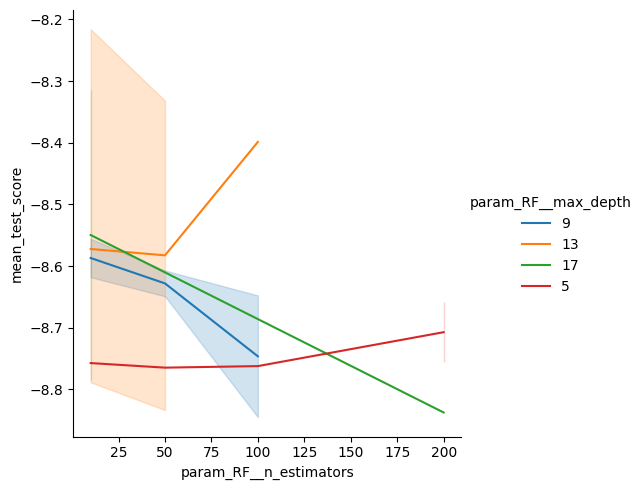

In [20]:
### Look at the combination of parameter values and the resulting score
sns.relplot(data=df_cv_results, y = "mean_test_score", x = "param_RF__n_estimators", 
            hue = 'param_RF__max_depth', 
            kind = 'line')

In [21]:
### Run best Model
best_rf_model = model.best_estimator_

In [22]:
best_rf_model

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('imputer',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['passenger_count']),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['trip_route'])])),
                ('RF',
                 RandomForestRegressor(max_depth=13, max_features='sqrt',
                                       min_samples_leaf=50, n_estimators=10))])

In [24]:
### Register in MLFlow
### Run best Model
features = list(X_train.columns)
target = y_train.name

with mlflow.start_run():
    tags = {"model": "RandomForestRegressor",
        "developer": "Gunnar",
        "dataset": f"{color}-taxi",
        "year": year,
        "month": month,
        "features": features,
        "target": target}
    mlflow.set_tags(tags)

    transformer = ColumnTransformer(
    [("imputer", SimpleImputer(strategy="most_frequent"), impute_columns),
    ("encoder", OneHotEncoder(drop=None,handle_unknown="ignore"), encode_columns)],
    remainder="passthrough")

    pipeline = Pipeline([("transformer", transformer),
                     ("RF", RandomForestRegressor(max_depth=13, max_features='sqrt', min_samples_leaf=50,
                      n_estimators=10))],
                    )
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)

    mlflow.sklearn.log_model(pipeline, "model")

/Users/gunnaroeh/neuefische/mle-model-deployment-project/.venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/gunnaroeh/neuefische/mle-model-deployment-project/.venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
